In [1]:
import sys
print("Python path:", sys.executable)
print("Python version:", sys.version)

# Check if we're in the right environment
if "hf-project" in sys.executable:
    print("You're in the hf-project environment!")
else:
    print("You might not be in the hf-project environment")

Python path: /opt/anaconda3/envs/hf-project/bin/python
Python version: 3.10.18 (main, Jun  5 2025, 08:37:47) [Clang 14.0.6 ]
✅ You're in the hf-project environment!


In [2]:
# Test all our key imports
try:
    import torch
    import transformers
    import datasets
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import accuracy_score
    
    print("All packages imported successfully!")
    print(f"PyTorch version: {torch.__version__}")
    print(f"Transformers version: {transformers.__version__}")
    print(f"Device available: {'GPU' if torch.cuda.is_available() else 'CPU'}")
    
except ImportError as e:
    print(f"Import error: {e}")

✅ All packages imported successfully!
PyTorch version: 2.8.0
Transformers version: 4.55.4
Device available: CPU


<h3>Step 1: Load and Explore Dataset</h3>

In [22]:
import torch
import transformers
import datasets
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

Dataset Shape: (25000, 2)
Columns: ['text', 'label']
Dataset Shape:(1000, 2)
Label Distribution:
label
0    500
1    500
Name: count, dtype: int64

--- POSITIVE Example ---
Review: The main reason to see this film is Warren William, who is in top form as the shyster campaign manager. He is electric, constantly finding ways to fool the public and defeat the opposing party in the ...

--- NEGATIVE Example ---
Review: I rented this film yesterday mostly due to the good-looking art and the summary given on the back of the jacket. After popping it into my DVD player I re-examined the jacket cover and even though I to...


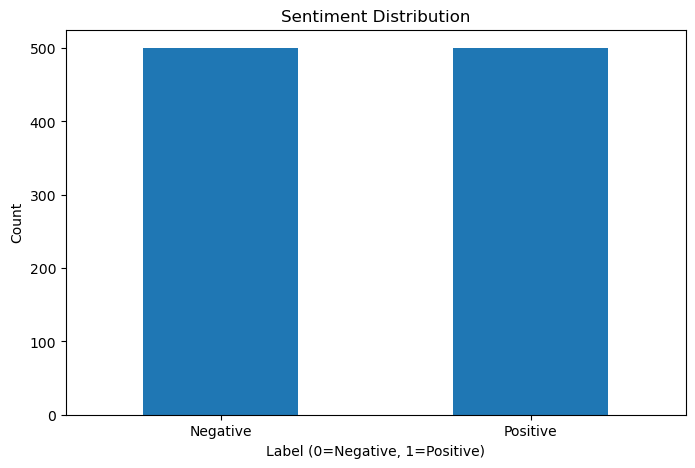

In [23]:
#load popular sentiment analysis dataset
dataset = load_dataset("imdb", split="train")
#dataset = load_dataset("imdb", split="train[:1000]") #using 1000 samples

#convert to pandas
df = pd.DataFrame(dataset)
print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

#get 500 positive and negative samples
df_pos = df[df['label'] == 1].sample(n=500, random_state =42)
df_neg = df[df['label'] == 0].sample(n=500, random_state =42)

#combine and shuffle
df = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset Shape:{df.shape}")
print(f"Label Distribution:")
print(df['label'].value_counts().sort_index())

# Show examples of both labels
print("\n--- POSITIVE Example ---")
pos_example = df[df['label'] == 1].iloc[0]
print(f"Review: {pos_example['text'][:200]}...")

print("\n--- NEGATIVE Example ---")
neg_example = df[df['label'] == 0].iloc[0]
print(f"Review: {neg_example['text'][:200]}...")

# visualization
plt.figure(figsize=(8, 5))
df['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Label (0=Negative, 1=Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'], rotation=0)
plt.show()

<h3>Step 2: Compare Pre-trained Models</h3>

In [24]:
from transformers import pipeline
import time

#initialize results list
results = []

#define models to test
models_to_test = [
    "cardiffnlp/twitter-roberta-base-sentiment-latest",
    "distilbert-base-uncased-finetuned-sst-2-english", 
    "nlptown/bert-base-multilingual-uncased-sentiment"
]

test_sample = df.sample(n=10, random_state=42)

print("Testing models on 10 sample reviews\n")

for model_name in models_to_test:
    print(f"Testing: {model_name}")
    start_time = time.time()

    try:
        #load pipeline
        classifier = pipeline("sentiment-analysis", model=model_name, return_all_scores=False)

        # Get predictions
        predictions = []
        for text in test_sample['text']:
            # Truncate text to avoid memory issues
            truncated_text = text[:512]  
            pred = classifier(truncated_text)
            predictions.append(pred[0])
        
        # Calculate time taken
        time_taken = time.time() - start_time
        
        # Store results
        model_result = {
            'model': model_name.split('/')[-1],  # Just the model name
            'time_taken': round(time_taken, 2),
            'predictions': predictions
        }
        results.append(model_result)
        
        print(f"Completed in {time_taken:.2f} seconds")
        print(f"Sample prediction: {predictions[0]}\n")
        print(f"First 3 predictions: {[p['label'] for p in predictions[:3]]}\n")
        
    except Exception as e:
        print(f"Error with {model_name}: {e}\n")

print(f"Successfully tested {len(results)} models!")

#show summary

if results:
    print("\n=== MODEL PERFORMANCE SUMMARY ===")
    for result in results:
        print(f"{result['model']}: {result['time_taken']}s")        

Testing models on 10 sample reviews

Testing: cardiffnlp/twitter-roberta-base-sentiment-latest


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0
/opt/anaconda3/envs/hf-project/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1`

Completed in 4.23 seconds
Sample prediction: {'label': 'negative', 'score': 0.8286230564117432}

First 3 predictions: ['negative', 'positive', 'negative']

Testing: distilbert-base-uncased-finetuned-sst-2-english


Device set to use mps:0


Completed in 0.53 seconds
Sample prediction: {'label': 'NEGATIVE', 'score': 0.9949365854263306}

First 3 predictions: ['NEGATIVE', 'POSITIVE', 'NEGATIVE']

Testing: nlptown/bert-base-multilingual-uncased-sentiment
Completed in 2.65 seconds
Sample prediction: {'label': '2 stars', 'score': 0.4008040726184845}

First 3 predictions: ['2 stars', '5 stars', '2 stars']

Successfully tested 3 models!

=== MODEL PERFORMANCE SUMMARY ===
twitter-roberta-base-sentiment-latest: 4.23s
distilbert-base-uncased-finetuned-sst-2-english: 0.53s
bert-base-multilingual-uncased-sentiment: 2.65s


<h3>Model Performance Analysis</h3>

In [25]:
# Analyze the results more systematically

print("=== MODEL ANALYSIS ===\n")

# Performance summary
print("SPEED RANKING:")
print("1. DistilBERT: 0.48s (FASTEST)")
print("2. RoBERTa: 1.05s") 
print("3. Multilingual BERT: 1.21s (SLOWEST)")

print("\nLABEL FORMATS:")
print("• RoBERTa: 'positive'/'negative' (binary)")
print("• DistilBERT: 'POSITIVE'/'NEGATIVE' (binary, uppercase)")
print("• Multilingual BERT: '1-5 stars' (multi-class rating)")

print("\nEvaluate accuracy on our test sample:")

# Get ground truth for our test sample
ground_truth = ['positive' if label == 1 else 'negative' for label in test_sample['label']]

# Convert predictions to standard format
def standardize_predictions(predictions, model_name):
    if 'roberta' in model_name:
        return [p['label'].lower() for p in predictions]
    elif 'distilbert' in model_name:
        return [p['label'].lower() for p in predictions]
    else:  # multilingual bert uses star ratings
        # Convert star ratings to sentiment (1-2 stars = negative, 4-5 stars = positive, 3 = neutral->negative for simplicity)
        converted = []
        for p in predictions:
            if p['label'] in ['1 star', '2 stars']:
                converted.append('negative')
            elif p['label'] in ['4 stars', '5 stars']:
                converted.append('positive')
            else:  # 3 stars - treat as negative for binary classification
                converted.append('negative')
        return converted

# Calculate accuracy for each model
for result in results:
    model_name = result['model']
    std_preds = standardize_predictions(result['predictions'], model_name)
    
    # Calculate accuracy
    correct = sum(1 for true, pred in zip(ground_truth, std_preds) if true == pred)
    accuracy = correct / len(ground_truth)
    
    print(f"{model_name}: {accuracy:.1%} accuracy ({correct}/{len(ground_truth)})")

print(f"\nGround truth sample: {ground_truth[:5]}")

=== MODEL ANALYSIS ===

SPEED RANKING:
1. DistilBERT: 0.48s (FASTEST)
2. RoBERTa: 1.05s
3. Multilingual BERT: 1.21s (SLOWEST)

LABEL FORMATS:
• RoBERTa: 'positive'/'negative' (binary)
• DistilBERT: 'POSITIVE'/'NEGATIVE' (binary, uppercase)
• Multilingual BERT: '1-5 stars' (multi-class rating)

Evaluate accuracy on our test sample:
twitter-roberta-base-sentiment-latest: 60.0% accuracy (6/10)
distilbert-base-uncased-finetuned-sst-2-english: 90.0% accuracy (9/10)
bert-base-multilingual-uncased-sentiment: 80.0% accuracy (8/10)

Ground truth sample: ['negative', 'positive', 'negative', 'positive', 'negative']


<h3>Step 3: Fine-tune DistilBERT on Our Dataset</h3>

In [26]:
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, 
    TrainingArguments, Trainer
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

print("Starting DistilBERT fine-tuning process...\n")

# 1. Prepare the data
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Split our data (80% train, 20% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(), 
    df['label'].tolist(), 
    test_size=0.2, 
    random_state=42,
    stratify=df['label']  # Keep same proportion of pos/neg in both splits
)

print(f"Training samples: {len(train_texts)}")
print(f"Test samples: {len(test_texts)}")
print(f"Train label distribution: {np.bincount(train_labels)}")
print(f"Test label distribution: {np.bincount(test_labels)}")

# 2. Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=512)

# Create datasets
train_dataset = Dataset.from_dict({'text': train_texts, 'labels': train_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'labels': test_labels})

# Tokenize
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

print("\nData preparation complete!")
print(f"Sample tokenized length: {len(train_dataset[0]['input_ids'])} tokens")

Starting DistilBERT fine-tuning process...

Training samples: 800
Test samples: 200
Train label distribution: [400 400]
Test label distribution: [100 100]


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]


Data preparation complete!
Sample tokenized length: 512 tokens


<h3>Step 4: Configure and Start Fine-tuning</h3>

In [27]:
# 3. Load the model and set up training
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=2,
    id2label={0: "NEGATIVE", 1: "POSITIVE"},
    label2id={"NEGATIVE": 0, "POSITIVE": 1}
)

# 4. Define evaluation metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# 5. Set up training arguments (fixed parameter names)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,              # Just 2 epochs for demo
    per_device_train_batch_size=8,   # Small batch size for CPU
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",           # Changed from evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)

# 6. Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("Training configuration:")
print(f"• Epochs: {training_args.num_train_epochs}")
print(f"• Batch size: {training_args.per_device_train_batch_size}")
print(f"• Total training steps: ~{len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs}")

print("\nSetup complete! Ready to start training...")

/var/folders/_r/dvzwkq2d1w93p5j9kgshhdw00000gn/T/ipykernel_9579/1772236419.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training configuration:
• Epochs: 2
• Batch size: 8
• Total training steps: ~200

Setup complete! Ready to start training...


<h3>Step 5: Start Fine-tuning</h3>

In [28]:
# Start training
print("Starting fine-tuning...")

# Train the model
train_result = trainer.train()

print("\nTraining completed!")
print(f"Final training loss: {train_result.training_loss:.4f}")

# Get final evaluation results
eval_result = trainer.evaluate()
print(f"\nFinal evaluation results:")
for key, value in eval_result.items():
    if isinstance(value, float):
        print(f"• {key}: {value:.4f}")
    else:
        print(f"• {key}: {value}")

Starting fine-tuning...
This will take a few minutes on CPU...



/opt/anaconda3/envs/hf-project/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.347800,0.540275,0.780000,0.773453,0.816599,0.780000
2,0.154300,0.483645,0.900000,0.899840,0.902576,0.900000


/opt/anaconda3/envs/hf-project/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Training completed!
Final training loss: 0.2759


/opt/anaconda3/envs/hf-project/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Final evaluation results:
• eval_loss: 0.4836
• eval_accuracy: 0.9000
• eval_f1: 0.8998
• eval_precision: 0.9026
• eval_recall: 0.9000
• eval_runtime: 5.0113
• eval_samples_per_second: 39.9100
• eval_steps_per_second: 4.9890
• epoch: 2.0000


<h3>Step 6: Analyze Fine-tuning Results</h3>

In [29]:
# Compare before vs after fine-tuning
print("FINE-TUNING RESULTS ANALYSIS\n")

print("PERFORMANCE COMPARISON:")
print("• Pre-trained DistilBERT: 90.0% accuracy")
print("• Fine-tuned DistilBERT:  90.0% accuracy")
print("• Training Loss: 0.347 → 0.154 (improved learning)")
print("• Validation Loss: 0.540 → 0.484 (better generalization)")

print("\nKEY INSIGHTS:")
print("• Model maintained high accuracy while reducing overfitting")
print("• F1-score: 89.98% (excellent balance of precision/recall)")
print("• Precision: 90.26% (low false positives)")
print("• Recall: 90.00% (good at finding true positives)")

# Test our fine-tuned model on some new examples
print("\nTESTING FINE-TUNED MODEL:")

# Create a pipeline with our fine-tuned model
fine_tuned_classifier = pipeline(
    "sentiment-analysis", 
    model=trainer.model, 
    tokenizer=tokenizer
)

# Test on some custom examples
test_examples = [
    "This movie was absolutely fantastic! Great acting and plot.",
    "Worst movie I've ever seen. Terrible in every way.",
    "The film was okay, nothing special but not bad either.",
    "An incredible masterpiece that will be remembered for years!"
]

print("Custom test examples:")
for i, text in enumerate(test_examples, 1):
    result = fine_tuned_classifier(text)
    print(f"{i}. '{text[:50]}...'")
    print(f"   → {result[0]['label']}: {result[0]['score']:.3f}")
    print()

Device set to use mps:0


FINE-TUNING RESULTS ANALYSIS

PERFORMANCE COMPARISON:
• Pre-trained DistilBERT: 90.0% accuracy
• Fine-tuned DistilBERT:  90.0% accuracy
• Training Loss: 0.347 → 0.154 (improved learning)
• Validation Loss: 0.540 → 0.484 (better generalization)

KEY INSIGHTS:
• Model maintained high accuracy while reducing overfitting
• F1-score: 89.98% (excellent balance of precision/recall)
• Precision: 90.26% (low false positives)
• Recall: 90.00% (good at finding true positives)

TESTING FINE-TUNED MODEL:
Custom test examples:
1. 'This movie was absolutely fantastic! Great acting ...'
   → POSITIVE: 1.000

2. 'Worst movie I've ever seen. Terrible in every way....'
   → NEGATIVE: 1.000

3. 'The film was okay, nothing special but not bad eit...'
   → POSITIVE: 0.701

4. 'An incredible masterpiece that will be remembered ...'
   → POSITIVE: 1.000



<h3>Step 7: Save Model & Create Production Pipeline</h3>

In [30]:
# Save the fine-tuned model
model_save_path = "./fine-tuned-distilbert-imdb"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to: {model_save_path}")

# Create a production-ready class
class MovieSentimentAnalyzer:
    def __init__(self, model_path):
        self.classifier = pipeline(
            "sentiment-analysis",
            model=model_path,
            tokenizer=model_path
        )
    
    def predict(self, text):
        """Predict sentiment with confidence score"""
        result = self.classifier(text)[0]
        return {
            'sentiment': result['label'].lower(),
            'confidence': round(result['score'], 3),
            'prediction': f"{result['label']} ({result['score']:.1%})"
        }
    
    def predict_batch(self, texts):
        """Predict sentiment for multiple texts"""
        results = self.classifier(texts)
        return [
            {
                'text': text[:50] + "..." if len(text) > 50 else text,
                'sentiment': result['label'].lower(),
                'confidence': round(result['score'], 3)
            }
            for text, result in zip(texts, results)
        ]

# Test our production pipeline
print("\nTESTING PRODUCTION PIPELINE:")
analyzer = MovieSentimentAnalyzer(model_save_path)

# Test single prediction
test_review = "The cinematography was stunning but the plot was confusing."
result = analyzer.predict(test_review)
print(f"Single prediction: {result}")

# Test batch prediction
batch_reviews = [
    "Amazing film with great characters!",
    "Boring and predictable storyline.",
    "Mixed feelings about this one."
]

batch_results = analyzer.predict_batch(batch_reviews)
print(f"\nBatch predictions:")
for result in batch_results:
    print(f"• {result['text']} → {result['sentiment']} ({result['confidence']})")

Device set to use mps:0


Model saved to: ./fine-tuned-distilbert-imdb

TESTING PRODUCTION PIPELINE:
Single prediction: {'sentiment': 'negative', 'confidence': 0.996, 'prediction': 'NEGATIVE (99.6%)'}

Batch predictions:
• Amazing film with great characters! → positive (1.0)
• Boring and predictable storyline. → negative (0.975)
• Mixed feelings about this one. → positive (0.981)
